<a href="https://colab.research.google.com/github/AnIsAsPe/RNN-Resumenes-de-Texto/blob/main/Notebooks/Resumen_de_textos_usando_seq2seq_LSTM_w2v_oct_2021_Atencion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IMPORTANTE: Antes de iniciar cambiar entorno de ejecución a GPU

# Cargar bibliotecas y Embeddings preentrenados y Capa de Atención

In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
# Revisar entorno colab
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16286131436874070631, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16185556992
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9501506778186054540
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [4]:
!pip install contractions

In [5]:
!pip install Rouge

<h3>Bibliotecas<h3>

In [6]:
import pandas as pd
import numpy as np
import gensim
import contractions
import re
from sklearn.model_selection import train_test_split
import tensorflow as tf

from tensorflow import keras
from tensorflow.data import Dataset  # Convierte conjuntos de datos de Python a tensores
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  # Crear diccionario para convertir palabras a indices y vs.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Rellenar con cero los vectores de las secuencias hasta la longitud máxima
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate #, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

from rouge import Rouge   #Evaluación 
import matplotlib.pyplot as plt

In [7]:
from tensorflow import keras
from tensorflow.data import Dataset  # Convierte conjuntos de datos de Python a tensores
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization  # Crear diccionario para convertir palabras a indices y vs.
from tensorflow.keras.preprocessing.sequence import pad_sequences # Rellenar con cero los vectores de las secuencias hasta la longitud máxima
from tensorflow.keras.layers import Embedding, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Concatenate #, Attention
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

<h3>Modelo Preentrenado Word2Vec<h3>

Utilizaremos los vectores word2vec preentrenados con el corpus GoogleNews.
Cuenta con 3 millones vectores de 300 dimensiones correspondientes a 3  palabras y frases en inglés


Referencia uso word embedings preentrenados con Keras en este [enlace](https://keras.io/examples/nlp/pretrained_word_embeddings/)


In [9]:
#!wget wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
#!gunzip /content/GoogleNews-vectors-negative300.bin.gz -d /content/drive/MyDrive/Datos/Embeddings/

In [10]:
w2v = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Datos/Embeddings/GoogleNews-vectors-negative300.bin',
                                                        binary=True)

In [11]:
print('Palabras en el modelo w2v: {:,} '.format(len(w2v.vocab)))
print('Dimensiones por embedding: ', w2v.vector_size)

Palabras en el modelo w2v: 3,000,000 
Dimensiones por embedding:  300


In [12]:
%%time
dic_embeddings_word2vec  = {palabra : w2v[palabra] for palabra in w2v.index2word}

CPU times: user 5.59 s, sys: 250 ms, total: 5.84 s
Wall time: 5.84 s


# Funciones

In [13]:
def preprocesar(texto):
    #quitar contracciones
    texto = contractions.fix(texto)

    #convertir en minúsculas
    texto = texto.lower()

    # eliminar texto no deseado
    texto = re.sub(r'<br />', ' ', texto)

    #texto = re.sub(r'https?:\/\/.*[\r\n]*', '', texto, flags=re.MULTILINE)
    #texto = re.sub(r'\<a href', ' ', texto)
    #texto = re.sub(r'&amp;', '', texto) 
    #texto = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', texto)
    #texto = re.sub(r'\'', ' ', texto)

    #dejar solo letras y números
    texto = re.sub('[^A-ZÜÖÄa-z0-9]+', ' ', texto)
    return(texto)

In [14]:
def Vectorizer(serie_pd, max_tokens= 20000):
    '''Crear diccionario para convertir palabras en índices '''
    text_ds = Dataset.from_tensor_slices(serie_pd).batch(128)  # transforma la serie a tensores
    vectorizer = TextVectorization(max_tokens = max_tokens  )  
    vectorizer.adapt(text_ds)   #similar a fit 
    return  vectorizer

In [15]:
def vectores_palabras(dic_vocabulario, dic_embeddings_palabras, embedding_dim):
    '''Obtiene una matriz donde cada renglón es el 'embedding vector' de una 
    palabra del vocabulario '''
    num_tokens = len(dic_vocabulario.keys()) 
    encontradas = 0
    # Inicializar matriz
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in dic_vocabulario.items():
        embedding_vector = dic_embeddings_palabras.get(word)
        if embedding_vector is not None:
            # los vectores no encontrados en el embeding se quedan en cero
            embedding_matrix[i] = embedding_vector
            encontradas += 1
    proporcion = encontradas/len(dic_vocabulario) *100
    print("{} palabras vectorizadas, que representan {:.1f}% de todas las palabras en el corpus".format(encontradas, proporcion))
    return embedding_matrix

In [ ]:
def crea_resumen(input_seq):
    # Codifica el texto como vectores de entrada
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    # Genera una secuencia vacía de longitud 1.
    target_seq = np.zeros((1,1))

    # Identifica la palabra 'tokenstart' como la primera palabra de la secuencia objetivo
    target_seq[0, 0] =  palabras_indices_resumen['tokenstart']
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        # Escoje la próxima palabra para el resumen
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = indices_palabras_resumen[sampled_token_index]

        # Mientras la palabra elejida no sea la final 'tokenend', anexa la palabra elejida al resumen
        if sampled_token!='tokenend':
            decoded_sentence += ' '+ sampled_token

        # Sal del ciclo while si se alcanza la longitud máxima o si se encuentra 'tokenend'.
        if (sampled_token == 'tokenend' or len(decoded_sentence.split()) >= (int(longitud_max_resumen-1))):
                stop_condition = True

        # Actualiza la secuencia objetivo (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Actualiza los estados internos para predecir la siguiente palabra, igualandolos al estado del tiempo anterior
        e_h, e_c = h, c

    return decoded_sentence

In [16]:
def seq2summary(input_seq):
    '''obtiene el resumen, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if((i != 0 and i != palabras_indices_resumen['tokenstart']) and i != palabras_indices_resumen['tokenend']):
        newString = newString + indices_palabras_resumen[i]+' '
    return newString

def seq2text(input_seq):
    '''obtiene la reseña, partiendo de los inidices correspondiente a cada palabra'''
    newString = ''
    for i in input_seq:
      if(i != 0):
        newString = newString + indices_palabras_reseña[i]+' '
    return newString

# Lectura de Datos y preparación de secuencias

In [17]:
df = pd.read_csv('/content/drive/MyDrive/Datos/AmazonReviews/Reviews.csv',
                 nrows=500000, usecols=['Summary', 'Text'], )
df = df.drop_duplicates(keep='first', ignore_index = True).dropna()
print(df.shape)
df.head()

(353877, 2)


,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [18]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 18120
doing well with it
the dog likes it and doing well with it. takes 2 per day. standard poodle is 11 years old.

Review # 44452
Not a good change
I used to have an Amazon subscription for Zico when it came in the cartons and wasn't made from concentrate. When Zico made the change, I decided to try one of their new bottles from a local store before starting a new subscription. I'm glad that I did because Zico now takes on par with the worst coconut waters I've ever had. It's not the worst, but it's down there with them. The difference is huge. It tastes slightly rotten now or you could imagine some of the coconut husk was accidentally added to the concentrate. I won't be getting Zico anymore.<br /><br />I tried several other brands to replace the old Zico but was disappointed in them all. I did finally find a replacement for Zico with <a href="http://www.amazon.com/gp/product/B003V8SO10">Naked 100% Naked Coconut Water, 11.2-Ounce Boxes (Pack of 12)</a>. It's as good as the

## Preprocesamiento de texto
- convertir a minuscualas
- expandir contracciones
- eliminar puntuación


In [19]:
%%time
for col in df.columns:
  df[col] = df[col].apply(preprocesar)


CPU times: user 20.7 s, sys: 100 ms, total: 20.8 s
Wall time: 20.8 s


## Agregar token que identifique el inicio y el final de la secuencia objetivo (resúmenes).

In [20]:
df['Summary'] = df['Summary'].apply(lambda x : 'tokenstart '+ x + ' tokenend')  #Identificador de comienzo y término

In [21]:
np.random.seed = 15
muestra = np.random.choice(range(len(df)), 5)
for i in muestra:
    print("\nReview #", i)
    print(df.loc[i, 'Summary'])
    print(df.loc[i,'Text'])    


Review # 97839
tokenstart works great  tokenend
this item works a little too well in fact the little sticky traps are covered so i actually need to order more they work well because you are able to push them as far down into the pot as you need to unlike other traps you would just hang in the general area they seem to be helping control our gnat problem though i would recommend a pesticide to go along with them the sticky paper helps cut down on the number of flying adults but eggs still exist in the pot that need to be taken care of as well 

Review # 214410
tokenstart disappointed expected crunchy but they are chewy tokenend
i love crispy crunchy quinoa puffs like rice krispies but quinoa with no sugar which i get from another vendor the price on these were better so i bought them and i am so disappointed they are not crispy at all they are so chewy they seem stale i will not order again 

Review # 134834
tokenstart need better packaging tokenend
crackers were fresh packaging was la

## Fijar longitud máxima de palabras en textos y resumenes

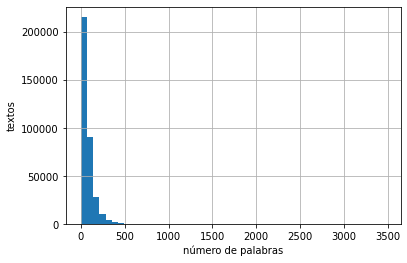


El 90% de los textos tiene 164 palabras


In [22]:
# ¿Cuantas palabras tienen cada texto?
palabras_reseña = df['Text'].apply(lambda x: len(str(x).split()))

hist = palabras_reseña.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("textos")
plt.show()

print('\nEl 90% de los textos tiene {:,.0f} palabras'.format(palabras_reseña.quantile(0.90)))

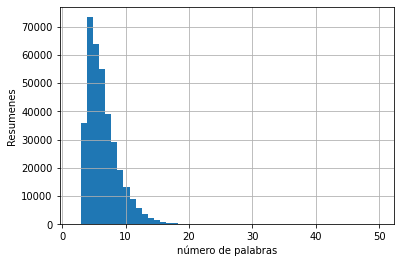


El 97.5% de los resumenes tiene 13 palabras


In [23]:
# ¿Cuantas palabras tienen cada titulo?
palabras_resumen = df['Summary'].apply(lambda x: len(str(x).split()))

hist = palabras_resumen.hist(bins=50)
hist.set_xlabel("número de palabras")
hist.set_ylabel("Resumenes")
plt.show()

print('\nEl 97.5% de los resumenes tiene {:,.0f} palabras'.format(palabras_resumen.quantile(0.975)))

In [24]:
longitud_max_reseña = palabras_reseña.quantile(0.90)     #164 palabras
longitud_max_resumen = palabras_resumen.quantile(0.975)  # 13 palabras

In [25]:
datos =  df[(palabras_reseña <= longitud_max_reseña ) & (palabras_resumen <= longitud_max_resumen)]
datos.shape   

(314858, 2)

# Dividir datos en conjunto de entrenamiento y prueba

In [26]:
x_train, x_test, y_train, y_test = train_test_split(datos['Text'], 
                                                    datos['Summary'], 
                                                    test_size=0.1, 
                                                    shuffle=True, 
                                                    random_state=0)
print('{} reseñas en el conjunto de entrenamiento\n{} reseñas en el conjunto de prueba'.format(len(x_train), len(x_test)))

283372 reseñas en el conjunto de entrenamiento
31486 reseñas en el conjunto de prueba


# Preparar las secuencias para ingresar al modelo

[Referencia](https://keras.io/examples/nlp/pretrained_word_embeddings/):


### 1)  Crear diccionario para convertir palabras en índices (en el entrenamiento) y otro para regresar índices a palabras (durante la predicción)

In [27]:
%%time
vectorizer_reseña = Vectorizer(x_train)

# Diccionarios de la secuencia de entrada
voc_reseña = vectorizer_reseña.get_vocabulary()  # lista con el vocabulario
palabras_indices_reseña = dict(zip(voc_reseña, range(len(voc_reseña))))
indices_palabras_reseña = dict(map(reversed, palabras_indices_reseña.items()))

CPU times: user 6.42 s, sys: 410 ms, total: 6.83 s
Wall time: 5.79 s


In [28]:
palabras_indices_reseña.keys()

dict_keys(['', '[UNK]', 'the', 'i', 'and', 'a', 'it', 'to', 'is', 'this', 'of', 'not', 'for', 'in', 'my', 'have', 'that', 'but', 'are', 'you', 'with', 'was', 'they', 'as', 'on', 'like', 'so', 'these', 'them', 'good', 'great', 'very', 'taste', 'product', 'will', 'be', 'at', 'just', 'one', 'or', 'do', 'flavor', 'if', 'coffee', 'all', 'would', 'am', 'we', 'love', 'from', 'tea', 'can', 'when', 'has', 'more', 'had', 'me', 'than', 'amazon', 'out', 'get', 's', 'no', 'really', 'other', 'too', 'some', 'only', 'up', 'much', 'use', 'were', 'about', 'buy', 'price', 'best', 'food', 'time', 'little', 'find', 'an', 'because', 'there', 'also', 'tried', 'what', 'your', 'make', 'been', 'better', 'did', 'well', 'does', 'even', 'try', 'chocolate', 'now', 'which', 'by', 'after', 'any', 'eat', 'again', 'he', 'she', 'used', 'bought', 'sugar', 'found', 'could', 'sweet', 'our', 'first', '2', 'cannot', 'free', 'order', 'store', 'delicious', 'tastes', 'drink', 'made', 'water', 'box', 'bag', 'cup', 'their', 'dog'

[UNK] es un token especial que se usara cuando se encuentren palabras que no están en el vocabulario.

In [29]:
vectorizer_resumen = Vectorizer(y_train)
# Diccionarios de la secuencia de entrada
voc_resumen = vectorizer_resumen.get_vocabulary()  # lista con el vocabulario
palabras_indices_resumen = dict(zip(voc_resumen, range(len(voc_resumen))))
indices_palabras_resumen = dict(map(reversed, palabras_indices_resumen.items()))


In [30]:
ejemplos = x_train.iloc[:2]
for ej in ejemplos:
  print(len(ej.split()))
  print(ej)

43
i have a german shepherd who was brought up with this food she looks great her coat is shiny and she is very very active i have no problem with the bynature products too bad i cannot get this food locally love it 
90
purchased the shampoo and conditioner after reading all the hype in magazines been using bed head products from my hair salon prior after 1 week using this i noticed my hair felt thinner and could feel more of my scalp this was a tad alarming my hair went to feeling somewhat healthy highlight my hair so has some processing stress but not much to feeling unhealthy texture was changed also noticed the color looked washed out after using products going in garbage can and back to shampoos conditioners from salon 


In [31]:
ejemplos_vec = ejemplos.apply(vectorizer_reseña)
for ej in ejemplos_vec:
  print(len(ej))
  print(ej)

43
tf.Tensor(
[   3   15    5 1669 2855  139   21  998   68   20    9   76  104  625
   30  147 1351    8 2002    4  104    8   31   31 2335    3   15   62
  346   20    2    1  195   65  206    3  114   60    9   76  720   48
    6], shape=(43,), dtype=int64)
90
tf.Tensor(
[  233     2  1183     4  1397    99   864    44     2  4065    13 11747
    88   204  1440  1731   195    49    14   510  7975  2020    99   145
   483   204     9     3   749    14   510   946  2642     4   109   294
    54    10    14  1747     9    21     5  2222 13902    14   510   426
     7   933   950   181  9488    14   510    26    53    66  3442  3425
    17    11    69     7   933  2503   250    21   954    83   749     2
   587   607  3447    59    99   204   195   254    13  1861    51     4
   193     7  4428  5105    49  7975], shape=(90,), dtype=int64)


In [32]:
%%time
x_train_vec = x_train.apply(vectorizer_reseña)
x_test_vec = x_test.apply(vectorizer_reseña)

y_train_vec = y_train.apply(vectorizer_resumen)
y_test_vec = y_test.apply(vectorizer_resumen)

CPU times: user 59min 28s, sys: 5min 6s, total: 1h 4min 35s
Wall time: 53min 22s


## 2) Rellenar cada secuencia hasta alcanzar la longitud máxima

In [33]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

ejemplos_seq =  pad_sequences(ejemplos_vec, maxlen = int(longitud_max_reseña), padding='post')
for ej in ejemplos_seq:
  print(len(ej))
  print(ej)

164
[   3   15    5 1669 2855  139   21  998   68   20    9   76  104  625
   30  147 1351    8 2002    4  104    8   31   31 2335    3   15   62
  346   20    2    1  195   65  206    3  114   60    9   76  720   48
    6    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0]
164
[  233     2  1183     4  1397    99   864    44     2  4065    13 11747
    88   204  1440  1731   195    49    14   510  7975  2020    99   145
   483   204 

In [34]:
%%time

x_train_seq  =  pad_sequences(x_train_vec, maxlen = int(longitud_max_reseña), padding='post') 
x_test_seq  =  pad_sequences(x_test_vec, maxlen = int(longitud_max_reseña), padding='post') 

y_train_seq  =  pad_sequences(y_train_vec, maxlen = int(longitud_max_resumen) , padding='post') 
y_test_seq  =  pad_sequences(y_test_vec, maxlen = int(longitud_max_resumen) , padding='post') 

CPU times: user 3min 33s, sys: 17 s, total: 3min 50s
Wall time: 3min 14s


## 3) Obtener la matriz de vectores para todas las palabras del vocabulario 

In [35]:
embedding_matrix_reseña = vectores_palabras(palabras_indices_reseña, dic_embeddings_word2vec , 300)
embedding_matrix_reseña.shape

17816 palabras vectorizadas, que representan 89.1% de todas las palabras en el corpus


(20000, 300)

In [36]:
embedding_matrix_resumen = vectores_palabras(palabras_indices_resumen, dic_embeddings_word2vec , 300)
embedding_matrix_resumen.shape

14576 palabras vectorizadas, que representan 72.9% de todas las palabras en el corpus


(20000, 300)

# Guardamos datos de entrada

In [37]:
import pickle
path = '/content/drive/MyDrive/Pickle_ Datos entrada RNN/'
tuple_inputs = ((embedding_matrix_resumen, embedding_matrix_reseña),
                (x_train_seq, x_test_seq,  y_train_seq, y_test_seq),
                (palabras_indices_resumen, palabras_indices_reseña),
                (indices_palabras_resumen, indices_palabras_reseña)
                )
pickle.dump(tuple_inputs, open (path + "tuple_inputs_RNN.pkl", 'wb'))

# Leemos el guardado modelo

In [38]:
import pickle
path = '/content/drive/MyDrive/Pickle_ Datos entrada RNN/'
tuple_inputs = pickle.load(open(path + "tuple_inputs_RNN.pkl", 'rb'))


# Diseño del modelo

* [referencia1](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

* [referencia2](https://humboldt-wi.github.io/blog/research/information_systems_1920/nlp_text_summarization_techniques/) 

## Diseño del ENCODER  y DECODER
(Codificador y Descodificador)

El Encoder lee la secuencia de entrada (reseña) y resume la información en el vector interno de estado (hidden state) y el vector de contexto. Al decodificador solo pasará el vector de estado interno.

El Decoder es inicializado con las el ultimo hidden state del LSTM y con el primer toquen de la secuencia objetivo (resumen) para generar la secuencia de salida


In [39]:
num_tokens_reseña = len(palabras_indices_reseña) 
num_tokens_resumen = len(palabras_indices_resumen)
embedding_dim = 300

In [40]:
K.clear_session() 
latent_dim = 320  # neuronas ocultas en cada LSTM en cada tiempo t.

# ENCODER   ================================================================

## EMBEDDING
#recibe los indices que corresponden a las palabras de las reseñas y las 
#regresa con el vector correpondiente del embedding

encoder_inputs = Input(shape = (int(longitud_max_reseña),))

enc_emb_lay = Embedding(num_tokens_reseña, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_reseña),
                    trainable=False)
enc_emb = enc_emb_lay(encoder_inputs)     

#LSTM 1
# procesa la secuencia de entrada y regresa otra secuencia que pasara a la
# capa LSTM 2 
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb) 


# LSTM 2
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara a la capa LSTM 3
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True) 
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1) 

#LSTM 3 
# procesa la secuencia de de salida de la capa LSTM anterior  y regresa otra 
# secuencia que pasara al mecanismo de atención y los estados h y c inicializarán
# el decodificador.

encoder_lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True) 
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2) 


# DECODIFICADOR ================================================================

decoder_inputs = Input(shape=(None,)) 
dec_emb_layer = Embedding(num_tokens_resumen, embedding_dim,
                    embeddings_initializer=keras.initializers.Constant(embedding_matrix_resumen),
                    trainable=False)
dec_emb = dec_emb_layer(decoder_inputs)

#LSTM 
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c]) 




## Mecanismo de atención

 [Fuente ](https://www.tensorflow.org/text/tutorials/nmt_with_attention)

In [41]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super().__init__()
    # For Eqn. (4), the  Bahdanau attention
    self.W1 = tf.keras.layers.Dense(units, use_bias=False)
    self.W2 = tf.keras.layers.Dense(units, use_bias=False)

    self.attention = tf.keras.layers.Attention()

  def call(self, query, value,
          #  mask
           ):
    # shape_checker = ShapeChecker()
    # shape_checker(query, ('batch', 't', 'query_units'))
    # shape_checker(value, ('batch', 's', 'value_units'))
    # shape_checker(mask, ('batch', 's'))

    # From Eqn. (4), `W1@ht`.
    w1_query = self.W1(query)
    # shape_checker(w1_query, ('batch', 't', 'attn_units'))

    # From Eqn. (4), `W2@hs`.
    w2_key = self.W2(value)
    # shape_checker(w2_key, ('batch', 's', 'attn_units'))

    query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
    # value_mask = mask

    context_vector, attention_weights = self.attention(
        inputs = [w1_query, value, w2_key],
        # mask=[query_mask, value_mask],
        return_attention_scores = True,
    )
    # shape_checker(context_vector, ('batch', 't', 'value_units'))
    # shape_checker(attention_weights, ('batch', 't', 's'))

    return context_vector, attention_weights

In [42]:
attention = BahdanauAttention(latent_dim)

In [43]:
context_vector, attention_weights = attention(decoder_outputs, encoder_outputs) # (query, value)

In [44]:
# Unión del decoder con la capa de atención

decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, context_vector])

# El Decoder calcula su salida mediante Softmax, que crea el vector de probabilidad 
# para determinar la secuencia final.

decoder_dense = TimeDistributed(Dense(embedding_matrix_resumen.shape[0], activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Modelo de entrenamiento

In [45]:
# Modelo definitivo

# Tupla con las entradas y las salidas
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 



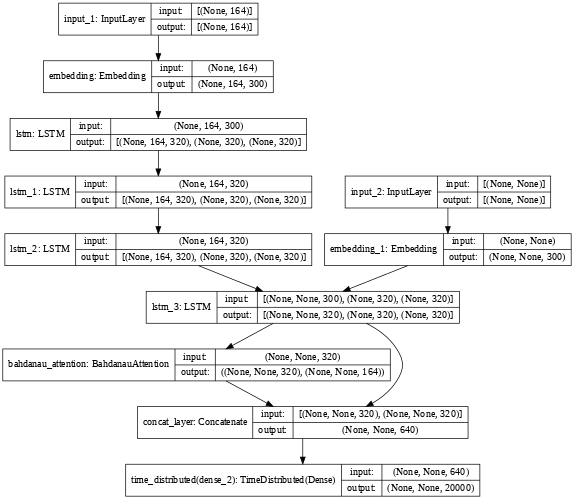

In [46]:
tf.keras.utils.plot_model( 
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=50,
)

In [47]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 164)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 164, 300)     6000000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 164, 320), ( 794880      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### Entrenamiento

In [48]:
model.compile(optimizer='rmsprop', 
              loss='sparse_categorical_crossentropy')

In [49]:
#%%time

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1) 

history = model.fit([x_train_seq, y_train_seq[:,:-1]], 
                    y_train_seq.reshape(y_train_seq.shape[0],
                                        y_train_seq.shape[1], 1)[:,1:],
                    epochs = 20, 

                    #terminar antes cuando no disminuya la función de pérdida
                    #callbacks = [EarlyStopping(monitor='val_loss',mode='min', 
                    #                         verbose=1)],
                    batch_size = 512, 
                    validation_data = ([x_test_seq,y_test_seq[:,:-1]], 
                                     y_test_seq.reshape(y_test_seq.shape[0],
                                                        y_test_seq.shape[1],
                                                        1)[:,1:]))


Epoch 1/20
554/554 [==============================] - 218s 377ms/step - loss: 2.2109 - val_loss: 1.9319
Epoch 2/20
554/554 [==============================] - 208s 375ms/step - loss: 1.8654 - val_loss: 1.8922
Epoch 3/20
554/554 [==============================] - 208s 375ms/step - loss: 1.7470 - val_loss: 1.6944
Epoch 4/20
554/554 [==============================] - 208s 375ms/step - loss: 1.6613 - val_loss: 1.6415
Epoch 5/20
554/554 [==============================] - 208s 375ms/step - loss: 1.5994 - val_loss: 1.6033
Epoch 6/20
554/554 [==============================] - 207s 375ms/step - loss: 1.5532 - val_loss: 1.5670
Epoch 7/20
554/554 [==============================] - 207s 374ms/step - loss: 1.5127 - val_loss: 1.5458
Epoch 8/20
554/554 [==============================] - 208s 375ms/step - loss: 1.4784 - val_loss: 1.5324
Epoch 9/20
554/554 [==============================] - 207s 374ms/step - loss: 1.4502 - val_loss: 1.5230
Epoch 10/20
554/554 [==============================] - 208s 375m

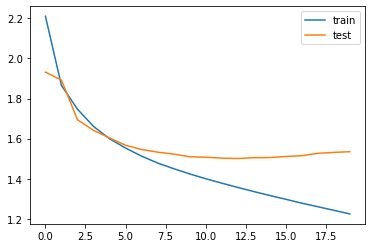

In [50]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.legend() 
plt.show()

In [71]:
# Guardar todo el modelo
model.save_weights('/content/drive/MyDrive/Modelos/WeightsM_oct21')

#Modelo de Inferencia y Generación de Texto

In [52]:
## Inferencia del codificador
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

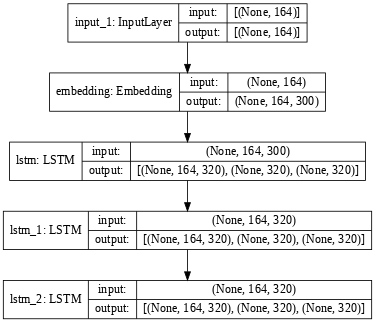

In [53]:
tf.keras.utils.plot_model( 
    encoder_model,
    to_file="encoder_model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

In [54]:
# Inferencia del decodificador

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(int(longitud_max_reseña), latent_dim))

# Obtener los embeddings de la secuencia del decodificador 
dec_emb2 = dec_emb_layer(decoder_inputs)

# Para predecir la siguiente palabra, el estado inicial se iguala al estado del tiempo anterior
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#Inferencia en modulo de atención
attention = BahdanauAttention(latent_dim)
context_vector, _ = attention( decoder_outputs2, decoder_hidden_state_input,)
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, context_vector])

# Se utiliza la capa con activación softmax para generar la distribución de probabilidad del vocabulario objetivo
decoder_outputs2 = decoder_dense(decoder_inf_concat)

# Modelo final del decoder
decoder_model = Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])

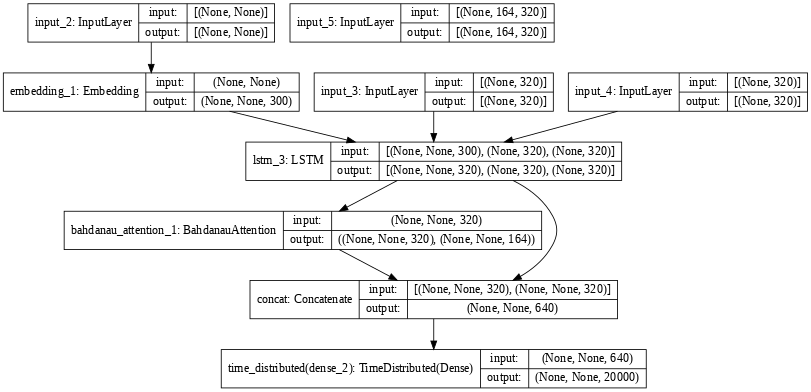

In [55]:
tf.keras.utils.plot_model( 
    decoder_model,
    to_file="model_decoder.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=60,
)

# Implementación del modelo de inferencia mediante
[fuente](https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/)

In [79]:
i = 33
print(i)
print("Reseña:",seq2text(x_test_seq[i]))
print("Resumen original:",seq2summary(y_test_seq[i]))
print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
print("\n")

33
Reseña: i love the smell of this stuff my husband and daughter are usually the ones drinking it and it always makes me want another cup of coffee so i can have some of that good smelling stuff it tastes great too by the way an all around win 
Resumen original: comfort coffee 
Resumen generado:  yummm great buy




In [68]:
for i in range(35,40):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

35
Reseña: wow the pulp inside makes a big difference it taste just like a real coconut water not from concentrate all natural drink better for you than a gatorade i have tried zico vita coco and o n e coconut waters taste nirvana company knows how to make a really great tasting product it is the best out there and the pulp inside makes it even better 
Resumen original: the best coconut water drink on the market 
Resumen generado:  coconut water


36
Reseña: the actual mate should be placed in a place for decoration the border of where the metal rim meets the gourd is faulty and hot water seeps out of it and onto your hand the bombilla is fine and the yerba was as well however i prefer rosamonte yerba 
Resumen original: mate for decoration not use 
Resumen generado:  not as described


37
Reseña: the [UNK] of the disc work great in the tassimo machine but it is too sweet and tastes a little fakey to me will not replace my hot chocolate discs when i run out frankly instant powdered hot 

In [72]:
for i in range(5,10):
  print(i)
  print("Reseña:",seq2text(x_test_seq[i]))
  print("Resumen original:",seq2summary(y_test_seq[i]))
  print("Resumen generado:",crea_resumen(x_test_seq[i].reshape(1, -1)))
  print("\n")

5
Reseña: this is always my first cup of coffee for the day strong but very smooth it never fails to wake me up and get me going and it is very nice to have the 50 pack available 
Resumen original: great coffee 
Resumen generado:  great coffee


6
Reseña: after eating this magic cereal my previously [UNK] jimmies were instantly [UNK] and my life has never been better no tears only dreams now 
Resumen original: my jimmies have never been the same 
Resumen generado:  ehh


7
Reseña: my dog a terrier has never had throwing up problems but after buying 2 bags of i [UNK] probiotic chunks at the grocery store because they were on sale half price which you rarely see with dog food she has started vomiting about twice a day i finally checked reviews on this food because it is the only thing different in her daily routine and saw a few others complaining of vomiting beware i am going back to our usual for her which is purina 
Resumen original: vomiting problems 
Resumen generado:  eh


8
Reseña